In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

1. Background Color Equalization
    - Match the size
    - Find Gain Transform using keypoints,descriptors (Using SIFT,SURF or ORB)(ORB in this case)
    - Find inliers using RANSAC Algorithm.If enough inliers are not found then caliberate the colour directly
    - If enough inliers are found then we find a transformation matrix based on those points and apply that transformation matrix to entire image for colour caliberation
2. Lip Detection and Interchanging
     - we use harr Cascade to first find face and then within this face we try to find mouth
     - once we have the mouth co-ordinates, we simply cut copy paste the mouth of one image over the other.
3. Laplacian Blending
    - we smooth it for visually appeasing results

### Find Gain Transform (DEF)

In [2]:
def find_matching_BGR(img_1, img_2, minHessian=400, inlierThreshold=10):
    if img_1 is None or img_2 is None:
        print("No data to match gain with!")
        return False, None, None

    if img_1.shape[:2] != img_2.shape[:2]:
        print("Image sizes do not match!")
        return False, None, None

    src_gray = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
    dst_gray = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

    orb = cv2.ORB_create()
    keypoints_src, descriptors_src = orb.detectAndCompute(src_gray, None)
    keypoints_dst, descriptors_dst = orb.detectAndCompute(dst_gray, None)

    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptors_src, descriptors_dst, k=2)

    # Extract good matches
    good_matches = []
    # print(matches)
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    max_dist = 0
    min_dist = 100

    for match in good_matches:
        dist = match.distance
        if dist < min_dist:
            min_dist = dist
        if dist > max_dist:
            max_dist = dist

    matches_src = [keypoints_src[match.queryIdx].pt for match in good_matches]
    matches_dst = [keypoints_dst[match.trainIdx].pt for match in good_matches]

    if len(matches_src) < 4:
#         print("Not enough matches found.")
        return False, None, None

    H, mask = cv2.findHomography(np.float32(matches_src), np.float32(matches_dst), cv2.RANSAC, 5)

    inliers_src = []
    inliers_dst = []

    for i in range(len(mask)):
        if mask[i] != 0:
            inliers_src.append(matches_src[i])
            inliers_dst.append(matches_dst[i])

    print("Number of inliers found:", len(inliers_src))

    if len(inliers_dst) < inlierThreshold:
#         print("Not enough inliers for gain matching.")
        return False,None,None

    BGRval_1 = np.zeros((len(inliers_src), 4), dtype=np.float32)
    BGRval_2 = np.zeros((len(inliers_dst), 4), dtype=np.float32)

    for i, inlier_src in enumerate(inliers_src):
        x = int(round(inlier_src[0]))
        y = int(round(inlier_src[1]))
        BGRval_1[i, 0] = img_1[y, x, 0]
        BGRval_1[i, 1] = img_1[y, x, 1]
        BGRval_1[i, 2] = img_1[y, x, 2]
        BGRval_1[i, 3] = 1

    for i, inlier_dst in enumerate(inliers_dst):
        x = int(round(inlier_dst[0]))
        y = int(round(inlier_dst[1]))
        BGRval_2[i, 0] = img_2[y, x, 0]
        BGRval_2[i, 1] = img_2[y, x, 1]
        BGRval_2[i, 2] = img_2[y, x, 2]
        BGRval_2[i, 3] = 1

    return True, BGRval_1, BGRval_2


In [3]:
# def find_BGR_for_region(img_1, img_2):
#     if img_1 is None or img_2 is None:
#         print("No data to match gain with!")
#         return False, None, None

#     if img_1.shape[:2] != img_2.shape[:2]:
#         print("Image sizes do not match!")
#         return False, None, None

#     channels1 = cv2.split(img_1)
#     channels2 = cv2.split(img_2)

#     BGRval_1 = np.empty((0, img_1.shape[0] * img_1.shape[1]), dtype=np.float32)
#     BGRval_2 = np.empty((0, img_2.shape[0] * img_2.shape[1]), dtype=np.float32)

#     for c in range(3):
#         BGRval_1 = np.vstack((BGRval_1, channels1[c].reshape(1, -1)))
#         BGRval_2 = np.vstack((BGRval_2, channels2[c].reshape(1, -1)))

#     ones_matrix = np.ones((1, img_1.shape[0] * img_1.shape[1]), dtype=np.float32)

#     BGRval_1 = np.vstack((BGRval_1, ones_matrix))
#     BGRval_2 = np.vstack((BGRval_2, ones_matrix))

#     BGRval_1 = np.transpose(BGRval_1)
#     BGRval_2 = np.transpose(BGRval_2)

#     BGRval_1 = BGRval_1.astype(np.float32)
#     BGRval_2 = BGRval_2.astype(np.float32)

#     return True, BGRval_1, BGRval_2

In [4]:
def find_gain_transform(src_color, dst_color, useKeypoints):
    if src_color.shape[:2] != dst_color.shape[:2]:
        print("Image sizes do not match!")
        return False,None

    print("Finding transform for gain consistency...")

    if src_color is None or dst_color is None:
        print("No data to match gain with!")
        return False,None

    transformMatrix = np.eye(4, 4, dtype=np.float32)

    if useKeypoints == True:
        found_matches,BGR_src,BGR_dst = find_matching_BGR(src_color, dst_color)
        if not found_matches:
#             print("No matches found for gain matching.")
            return False,None
    else:
        found_matches,BGR_src,BGR_dst = find_BGR_for_region(src_color, dst_color)
        
        if not found_matches:
#             print("No matches found for gain matching with find_BGR_for_region.")
            return False,None
        # print(BGR_src)
        # print(BGR_dst)
    BGR_src_transpose = np.transpose(BGR_src)
    transformMatrix = np.linalg.inv(BGR_src_transpose.dot(BGR_src)).dot(BGR_src_transpose).dot(BGR_dst)
    transformMatrix = np.transpose(transformMatrix)

    print("Transform found.")
    return True,transformMatrix


In [5]:
def apply_gain_transform(img, transform_matrix):
    l, b, _ = img.shape

    # Convert the image to a matrix of shape (l*b,4)
    image_matrix = np.c_[img.reshape(l*b, -1), np.ones(l*b)]

    # Multiply the image matrix with the transform matrix
    transformed_matrix = np.dot(image_matrix, transform_matrix.T)

    # Extract the transformed image channels
    transformed_red = transformed_matrix[:, 0].reshape(l, b).astype(np.uint8)
    transformed_green = transformed_matrix[:, 1].reshape(l, b).astype(np.uint8)
    transformed_blue = transformed_matrix[:, 2].reshape(l, b).astype(np.uint8)
    # print(transformed_matrix[:,3])
    # Create the transformed image
    transformed_image = cv2.merge((transformed_red, transformed_green, transformed_blue))

    return transformed_image,transformed_matrix

In [6]:
def mean_stddev(image):
    num_pixels = image.size
    mean = np.sum(image) / num_pixels
    variance = np.sum((image - mean) ** 2) / num_pixels
    std_dev = np.sqrt(variance)
    return mean, std_dev

In [7]:
def color_calibrate(source_img, target_img):
    # Convert images to LAB color space
    source_lab = cv2.cvtColor(source_img, cv2.COLOR_BGR2LAB)
    target_lab = cv2.cvtColor(target_img, cv2.COLOR_BGR2LAB)

    # Splitting the LAB images to different channels
    l_source, a_source, b_source = cv2.split(source_lab)
    l_target, a_target, b_target = cv2.split(target_lab)
    
    # Calculating the mean and std deviation of l, a, and b channels for the source
    mean_l_source, std_l_source = mean_stddev(l_source)
    mean_a_source, std_a_source = mean_stddev(a_source)
    mean_b_source, std_b_source = mean_stddev(b_source)

    # Calculating the mean and std deviation of l, a, and b channels for the target
    mean_l_target, std_l_target = mean_stddev(l_target)
    mean_a_target, std_a_target = mean_stddev(a_target)
    mean_b_target, std_b_target = mean_stddev(b_target)
    
    # Adjusting the l, a, b channels by the differences in means and std deviations
    l_result = (l_source - mean_l_source) * (std_l_target / std_l_source) + mean_l_target
    a_result = (a_source - mean_a_source) * (std_a_target / std_a_source) + mean_a_target
    b_result = (b_source - mean_b_source) * (std_b_target / std_b_source) + mean_b_target

    # Clipping the results and converting to 8-bit unsigned integers
    l_result = np.clip(l_result, 0, 255).astype(np.uint8)
    a_result = np.clip(a_result, 0, 255).astype(np.uint8)
    b_result = np.clip(b_result, 0, 255).astype(np.uint8)
    
    # Merging the channels and converting back to BGR color space
    result_lab = cv2.merge([l_result, a_result, b_result])
    result_bgr = cv2.cvtColor(result_lab, cv2.COLOR_LAB2BGR)

    return result_bgr


(281, 500, 3)
(281, 500, 3)
Finding transform for gain consistency...
Color Callibiration Done


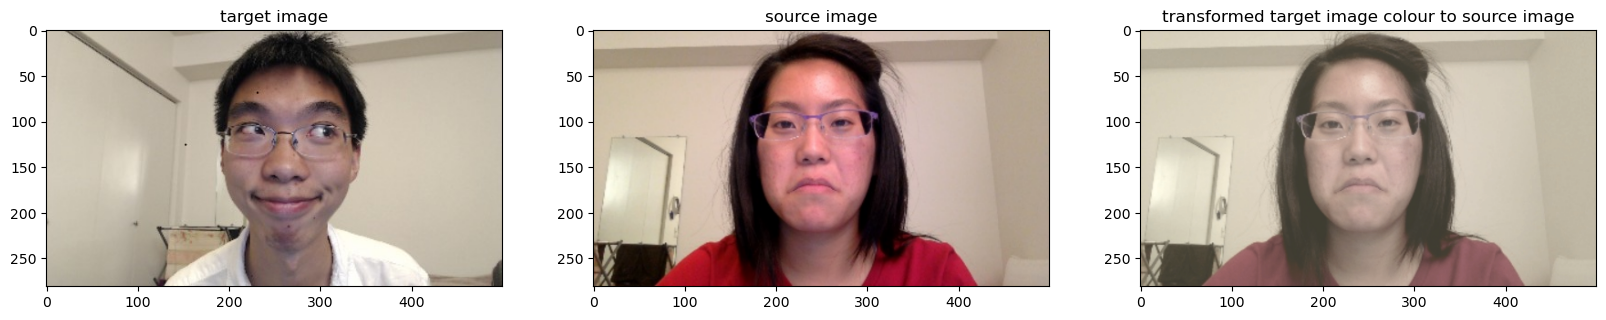

In [8]:
target_image = cv2.imread('./img2.jpeg')
source_image = cv2.imread('./img1.png')

# target_image = cv2.imread('./img1.png')
# source_image = cv2.imread('./img2.jpeg')


# Convert BGR to RGB (OpenCV reads images in BGR format)
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)

# Make size equal
if target_image.shape[:2] != source_image.shape[:2]:
    source_image = cv2.resize(source_image, (target_image.shape[1], target_image.shape[0]))

print(target_image.shape)
print(source_image.shape)

found,transform_matrix = find_gain_transform(target_image, source_image, useKeypoints=True)

if(found):
#     print("Transform found.Done")
    transform_matrix = np.array(transform_matrix)
    transformed_image,result = apply_gain_transform(source_image, transform_matrix)
else:
#     print("Transform not found.Done.Doing color Callibration due to lack of key points")   
    transformed_image = color_calibrate(source_image,target_image)
print("Color Callibiration Done")

plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(target_image)
plt.title("target image")
plt.subplot(1, 3, 2)
plt.imshow(source_image)
plt.title("source image")
plt.subplot(1, 3, 3)
plt.imshow(transformed_image)
plt.title("transformed target image colour to source image")
plt.show()

In [9]:
image1 = np.copy(transformed_image)
image2 = np.copy(target_image)